In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
X=np.load("Featuresnpy.sec")
y=np.load("Labelsnpy.sec")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=100, random_state=42)

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='viridis')

In [5]:
# Helper Functions (can be used)

from colorsys import hls_to_rgb

def get_distinct_colors(n):

    colors = []

    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append([hls_to_rgb(h, l, s)[0],hls_to_rgb(h, l, s)[1], hls_to_rgb(h, l, s)[2]] )

    return np.array(colors)

def determineClusterColors(clusters, k, f):
    colors=get_distinct_colors(k)
    clusterColor=[]

    for p in clusters:

        if p[1]==0:
            clusterColor.append(colors[p[0]])
        else:
            scalar=(p[1])*f
            color=colors[p[0]]+scalar

            color=np.where(color>0.99,0.99,color)
            clusterColor.append(color)
    return clusterColor

def classifyCluster(x, cluster):
    N=x.shape[0]

    clusters=[]
    for i in range(N):
        distance=np.linalg.norm(np.power(x[i,:]-cluster,2), axis=1)
        minArg=np.argmin(distance)
        clusters.append([minArg, distance[minArg]])

    return clusters

In [6]:
# K-Means Example
num_centroids = 5
kmeans = KMeans(n_clusters=num_centroids, random_state=42)
kmeans.fit(X)
centroids = kmeans.cluster_centers_

clusters=classifyCluster(X_train, centroids)
colors=determineClusterColors(clusters, num_centroids, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=colors)
plt.title("KMeans")
for i,c in enumerate(centroids):
    plt.plot(c[0], c[1], marker="x", ls="", c="black")

C:\Users\t00002k9\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\t00002k9\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\t00002k9\AppData\Local\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\t00002k9\AppData\Local\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executab

In [14]:
# === TODO: Implement Laplacian Embedding ===
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
import numpy as np

def laplacian_embedding(X, n_components=2, n_neighbors=10, sigma=None, normalized=True, random_state=42):
    """
    Compute Laplacian Eigenmaps embedding.
    
    Parameters
    ----------
    X : np.ndarray, shape (N, d)
        Input data.
    n_components : int
        Number of embedding dimensions to return.
    n_neighbors : int
        k for k-NN graph.
    sigma : float or None
        Heat kernel width. If None, set to median neighbor distance.
    normalized : bool
        If True, use normalized Laplacian (I - D^{-1/2} W D^{-1/2}).
        Otherwise, unnormalized Laplacian (D - W).
    random_state : int
        Random seed (not used directly but kept for reproducibility).
    
    Returns
    -------
    Z : np.ndarray, shape (N, n_components)
        Low-dimensional embedding (Laplacian Eigenmaps).
    """
    # 1) Build k-NN graph with distances
    A = kneighbors_graph(X, n_neighbors=n_neighbors, mode='distance', include_self=False, n_jobs=-1)
    
    # 2) Convert distances -> heat kernel weights
    distances = A.data.copy()
    # Avoid degenerate sigma
    if sigma is None:
        # Robust scale: median of non-zero distances
        sigma = np.median(distances)
        if not np.isfinite(sigma) or sigma <= 0:
            sigma = np.mean(distances) + 1e-8
    weights = np.exp(-(distances**2) / (2.0 * sigma**2))
    W = A.copy()
    W.data = weights
    
    # 3) Symmetrize W
    W = 0.5 * (W + W.T)
    
    # 4) Graph Laplacian
    L = csgraph.laplacian(W, normed=normalized)
    
    # 5) Smallest (n_components+1) eigenvectors (skip the first trivial one)
    k = n_components + 1
    # Using eigsh on symmetric PSD Laplacian
    vals, vecs = eigsh(L, k=k, which='SM')
    # Sort pairs (just in case)
    order = np.argsort(vals)
    vals = vals[order]
    vecs = vecs[:, order]
    
    # Skip the first eigenvector (constant)
    Z = vecs[:, 1:k]
    return Z

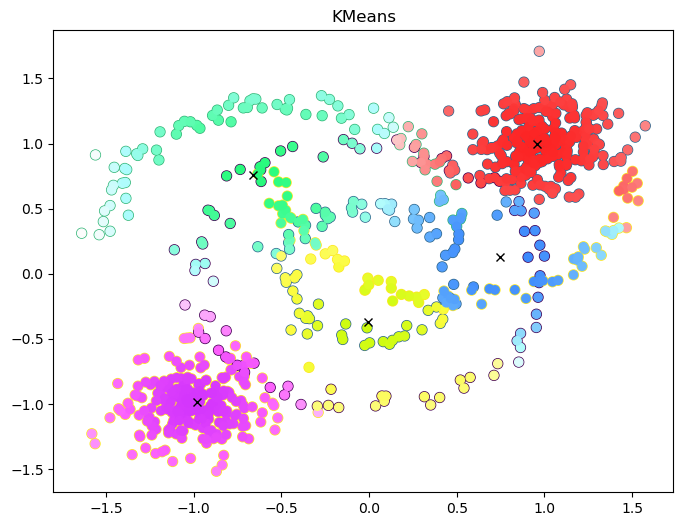

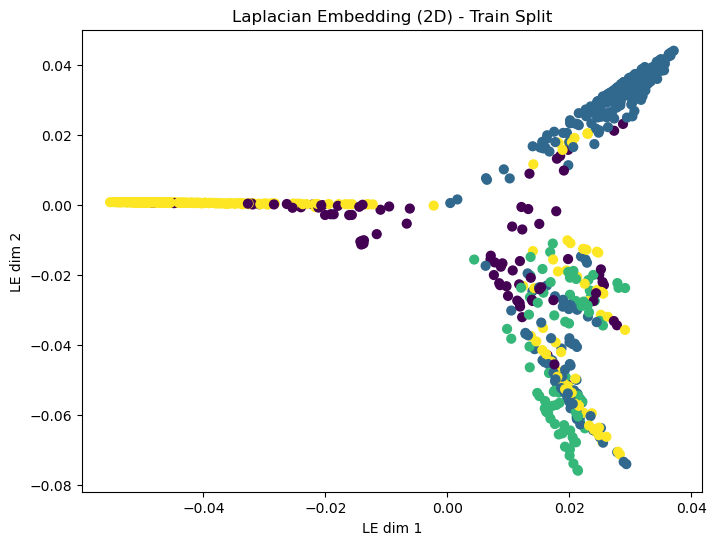

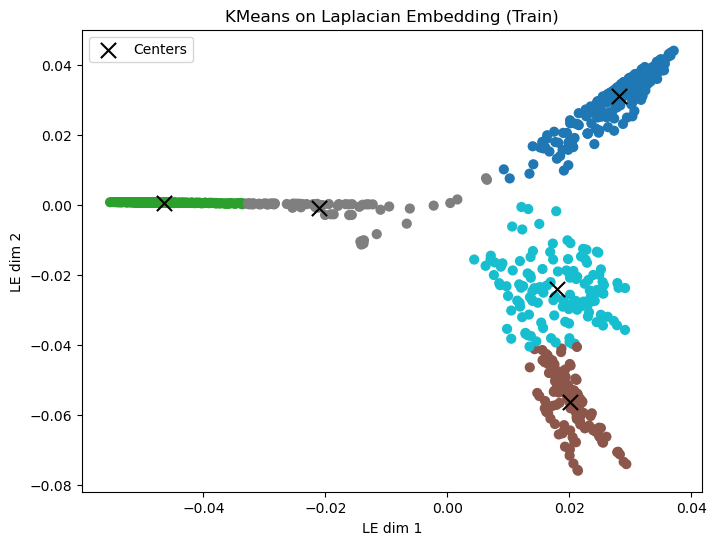

In [15]:
# === TODO: Use Laplacian embedding + apply k-means to transformed data ===

# 2D embedding for visualization
Z_2d = laplacian_embedding(X, n_components=2, n_neighbors=10, normalized=True)

# Recreate the same splits as above, but this time as indices (to slice the embedding)
idx_all = np.arange(X.shape[0])
idx_trainval, idx_test = train_test_split(idx_all, test_size=100, random_state=42, shuffle=True)
idx_train, idx_val = train_test_split(idx_trainval, test_size=100, random_state=42, shuffle=True)

# Visualize the training set in embedded space
plt.figure(figsize=(8, 6))
plt.scatter(Z_2d[idx_train, 0], Z_2d[idx_train, 1], c=y[idx_train], s=40, cmap='viridis')
plt.title("Laplacian Embedding (2D) - Train Split")
plt.xlabel("LE dim 1")
plt.ylabel("LE dim 2")
plt.show()

# KMeans on embedded train data (use same number of centroids as above)
kmeans_le = KMeans(n_clusters=num_centroids, random_state=42)
kmeans_le.fit(Z_2d[idx_train])

# Plot clusters in embedded space
plt.figure(figsize=(8, 6))
plt.scatter(Z_2d[idx_train, 0], Z_2d[idx_train, 1], c=kmeans_le.labels_, s=40, cmap='tab10')
plt.title("KMeans on Laplacian Embedding (Train)")
plt.xlabel("LE dim 1")
plt.ylabel("LE dim 2")

# Mark cluster centers (in embedded space)
centers = kmeans_le.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=120, c='black', label='Centers')
plt.legend()
plt.show()

Validation Accuracy (LE + LR): 0.7900
Test Accuracy (LE + LR):       0.7600

Classification report (Test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.74      1.00      0.85        43
           2       0.00      0.00      0.00        12
           3       0.79      0.82      0.80        40

    accuracy                           0.76       100
   macro avg       0.38      0.46      0.41       100
weighted avg       0.63      0.76      0.69       100



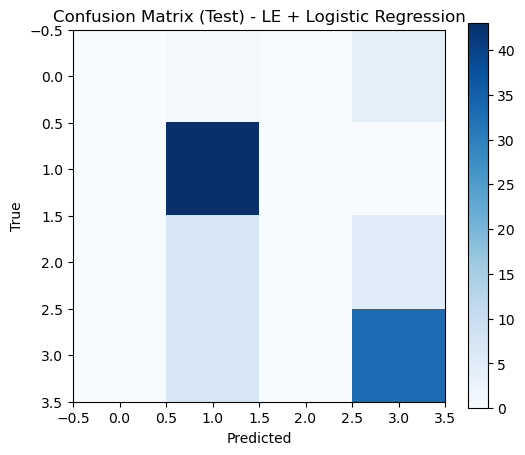

In [16]:
# === TODO: Apply logistic regression on the transformed data (Laplacian embedding) ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Higher-dimensional embedding for classification
Z_10d = laplacian_embedding(X, n_components=10, n_neighbors=12, normalized=True)

Z_train = Z_10d[idx_train]
Z_val   = Z_10d[idx_val]
Z_test  = Z_10d[idx_test]

y_train_le = y[idx_train]
y_val_le   = y[idx_val]
y_test_le  = y[idx_test]

# Logistic Regression (multi-class)
logreg = LogisticRegression(max_iter=5000, solver='lbfgs', multi_class='auto', random_state=42)
logreg.fit(Z_train, y_train_le)

# Evaluate
y_pred_val = logreg.predict(Z_val)
y_pred_test = logreg.predict(Z_test)

val_acc = accuracy_score(y_val_le, y_pred_val)
test_acc = accuracy_score(y_test_le, y_pred_test)

print(f"Validation Accuracy (LE + LR): {val_acc:.4f}")
print(f"Test Accuracy (LE + LR):       {test_acc:.4f}")

# (Optional) Detailed report
print("\nClassification report (Test):")
print(classification_report(y_test_le, y_pred_test))

# (Optional) Confusion matrix
cm = confusion_matrix(y_test_le, y_pred_test)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Test) - LE + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()